In [81]:
#cd t:\freely_moving_ephys\ephys_recordings\101120\G6H28P6LT\hf4_wn
#cd \\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs_Oct07a


In [82]:
cd t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\hf1_wn

t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\hf1_wn


In [83]:
ls

 Volume in drive T is 8tb internal A
 Volume Serial Number is 7481-8BF5

 Directory of t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\hf1_wn

10/28/2020  10:16 PM    <DIR>          .
10/28/2020  10:16 PM    <DIR>          ..
10/15/2020  02:25 PM    <DIR>          .phy
10/15/2020  10:59 AM     1,272,709,120 101520_G6H28P6LT_hf1_wn_Ephys.bin
10/28/2020  04:44 PM           464,701 101520_G6H28P6LT_hf1_wn_ephys.json
10/15/2020  10:59 AM         1,398,216 101520_G6H28P6LT_hf1_wn_Ephys_BonsaiBoardTS.csv
10/15/2020  10:59 AM         1,475,904 101520_G6H28P6LT_hf1_wn_Ephys_BonsaiTS.csv
10/15/2020  10:59 AM         1,165,200 101520_G6H28P6LT_hf1_wn_Ephys_DirectBoardTS.csv
10/15/2020  01:18 PM       636,354,560 101520_G6H28P6LT_hf1_wn_Ephys_int16_med1_nch16.bin
10/15/2020  01:18 PM        40,309,207 101520_G6H28P6LT_hf1_wn_Ephys_medianTrace.mat
10/15/2020  10:59 AM       170,308,866 101520_G6H28P6LT_hf1_wn_REYE.avi
10/15/2020  10:59 AM           339,055 101520_G6H28P6LT_hf1_wn_REYE_Bon

In [84]:
eye_file =   "101120_G6H28P6LT_hf4_wnReye.nc"
world_file = '101120_G6H28P6LT_hf4_wnworld.nc'
ephys_file = '101120_G6H28P6LT_hf4_wn_ephys.json'

eye_file = '092820_J524RT_whitenoise_hfReye.nc'
world_file = '092820_J524RT_whitenoise_hfworld.nc'
ephys_file = '092820_J524RT_whitenoise_hf_ephys.json'

eye_file =   "101520_G6H28P6LT_hf1_wnReye.nc"
world_file = '101520_G6H28P6LT_hf1_wnworld.nc'
ephys_file = '101520_G6H28P6LT_hf1_wn_ephys.json'

In [85]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [86]:
# load worldcam
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])



In [87]:
#resize worldcam to make more manageable
sz = world_vid_raw.shape
downsamp = 0.5
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps
world_data

<xarray.Dataset>
Dimensions:      (frame: 34879, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 ... 34874 34875 34876 34877 34878
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8

Text(0.5, 0, 'deltaT')

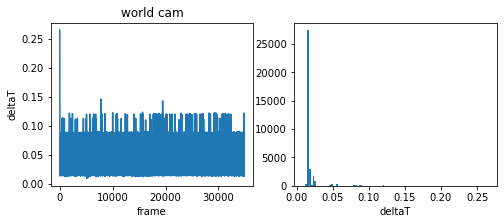

In [88]:
# plot worldcam timing
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(worldT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('world cam')
axs[1].hist(np.diff(worldT),100);axs[1].set_xlabel('deltaT')

Text(0.5, 1.0, 'mean worldcam')

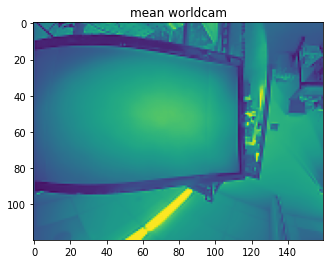

In [89]:
# plot mean world image
plt.imshow(np.mean(world_vid,axis=0)); plt.title('mean worldcam')

In [90]:
# read ephys data
ephys_data = pd.read_json(ephys_file)
ephys_data


,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,spikeT,waveform,t0
0,296.8,55.0,mua,22.144421,0,1,6.123379,mua,4059,0,"[0.5813, 0.7810333333, 0.9637666667, 1.0751666...","[0.0217636153, -0.0027860794, 0.0003928032, -0...",38934.771289
1,310.6,0.0,mua,22.081774,1,2,0.089007,noise,59,0,"[9.8903, 15.6518333333, 48.2070666667, 55.4052...","[0.040814478, 0.0280256215, 0.0252718385, 0.02...",38934.771289
2,348.9,0.0,mua,24.272587,1,2,0.045258,noise,30,0,"[16.5664333333, 29.9438333333, 46.5118666667, ...","[0.0353595726, 0.0198887475, 0.0187783726, 0.0...",38934.771289
3,284.1,0.0,mua,21.977932,2,3,0.144825,noise,96,0,"[6.7763666666999995, 23.1833333333, 27.2912666...","[0.0065002684, -0.0032696922000000003, -0.0018...",38934.771289
4,563.6,0.0,mua,28.486382,2,3,0.116162,noise,77,0,"[21.5250666667, 28.1116, 56.5586, 61.903266666...","[0.013502049300000001, 0.0103226667, 0.0071341...",38934.771289
5,339.0,0.0,good,29.565430,2,3,1.069592,noise,709,0,"[3.1428666667, 5.2027333333, 5.6421333333, 6.0...","[0.0308295377, 0.021918734500000002, 0.0201007...",38934.771289
6,764.6,2.5,good,30.485237,3,4,4.263284,good,2826,0,"[0.7644000000000001, 1.2200333333, 1.247066666...","[0.0100395055, 0.0036554276, 0.0046803541, 0.0...",38934.771289
7,310.6,0.0,mua,23.928997,3,4,0.058835,noise,39,0,"[5.0655333333, 5.1182333333, 5.6449666667, 6.5...","[0.013078308700000001, -0.0067312457, -0.00299...",38934.771289
8,341.1,NaN,mua,23.035574,3,4,0.009052,noise,6,0,"[13.6124333333, 107.6952666667, 134.8007666667...","[0.0268254541, 0.0060632341, 0.0077390019, 0.0...",38934.771289
9,228.0,0.0,mua,17.849028,5,6,0.158402,noise,105,0,"[9.8506, 22.1748333333, 28.1192, 42.3373333333...","[-0.0016718324, 0.007889336, 0.0057400456, 0.0...",38934.771289


In [91]:
# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

38934.771289

In [92]:
# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values
units

array([ 6, 32, 33, 35, 37], dtype=int64)

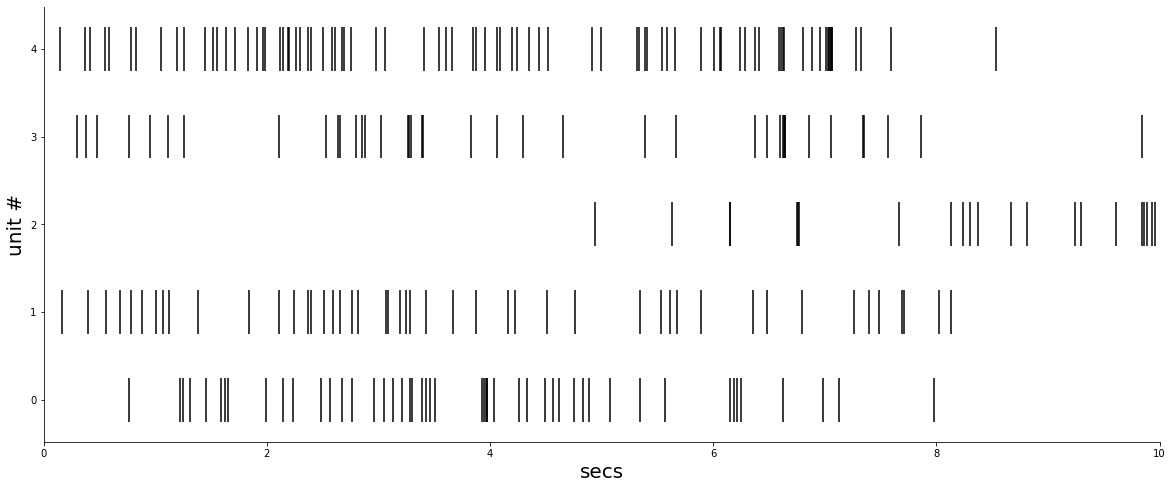

In [93]:
#spike rasters
fig, ax = plt.subplots(figsize=(20,8))
ax.fontsize = 20
for i,ind in enumerate(goodcells.index):
   plt.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25)
   plt.xlim(0, 10); plt.xlabel('secs',fontsize = 20); plt.ylabel('unit #',fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('spikeraster.pdf')



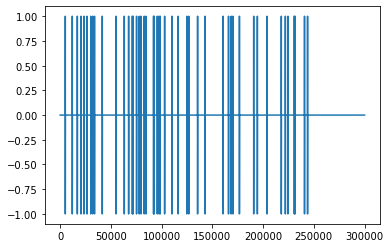

In [94]:
# generate wave file
spk =np.array(ephys_data.at[units[1],'spikeT'])

datarate = 30000
rate = 44100    # samples per second
Tmax = 10           # sample duration (seconds)
f = 440.0       # sound frequency (Hz)
# Compute waveform samples
t = np.linspace(0, Tmax, Tmax*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in spk[spk<Tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
wavio.write("spike.wav", x, datarate, sampwidth=1)


<xarray.DataArray 'timestamps' (frame: 35690)>
array([38934.392387, 38934.382435, 38934.398543, ..., 39597.572693,
       39597.588802, 39597.604911])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 35685 35686 35687 35688 35689
    timestamps  (frame) float64 3.893e+04 3.893e+04 ... 3.96e+04 3.96e+04

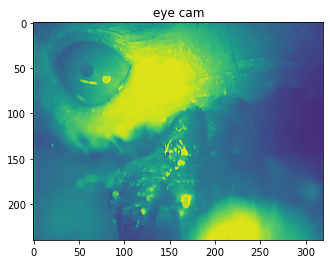

In [95]:
#load eye data
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps
eyeT

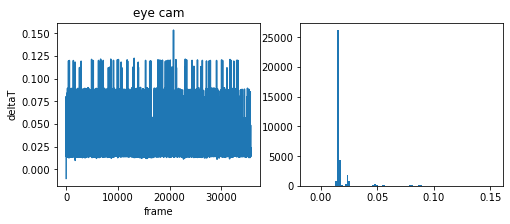

In [96]:
# plot eye timestamps
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(eyeT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('eye cam')
axs[1].hist(np.diff(eyeT),100);

Text(0, 0.5, 'phi')

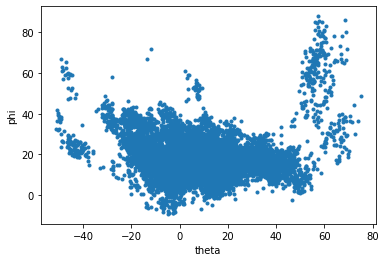

In [97]:
#plot eye postion across recording
eye_params = eye_data['REYE_ellipse_params']
plt.plot(eye_params.sel(ellipse_params = 'theta')*180/3.1415,eye_params.sel(ellipse_params = 'phi')*180/3.1415,'.')
plt.xlabel('theta'); plt.ylabel('phi')

In [98]:
# adjust eye/world/top times relative to ephys
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 35690)>
 array([-3.78902500e-01, -3.88854500e-01, -3.72745500e-01, ...,
         6.62801405e+02,  6.62817513e+02,  6.62833623e+02])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 35685 35686 35687 35688 35689
     timestamps  (frame) float64 3.893e+04 3.893e+04 ... 3.96e+04 3.96e+04,
 <xarray.DataArray 'timestamps' (frame: 34879)>
 array([-3.78998250e-01, -1.14172750e-01, -9.80512500e-02, ...,
         6.62793431e+02,  6.62805955e+02,  6.62822077e+02])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 34874 34875 34876 34877 34878
     timestamps  (frame) float64 3.893e+04 3.893e+04 ... 3.96e+04 3.96e+04)

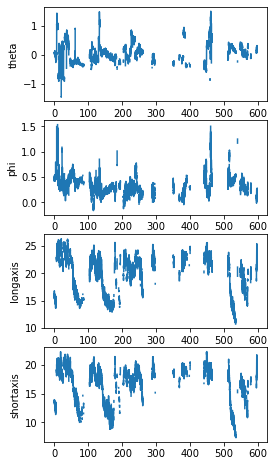

In [99]:
#plot eye variables
fig,axs = plt.subplots(4,1,figsize = (4,8))
for i,val in enumerate(eye_params.ellipse_params[0:4]):
    axs[i].plot(eyeT,eye_params.sel(ellipse_params = val))
    axs[i].set_ylabel(val.values)
    

In [100]:
# calculate eye veloctiy
dEye = np.diff(eye_params.sel(ellipse_params = 'theta'))*180/3.14159
eye_vid.shape

(35690, 240, 320)

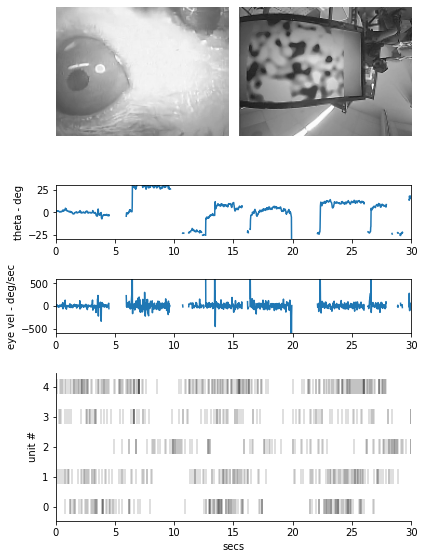

In [101]:
# plot data figure

fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(6,2)
axEye = fig.add_subplot(gs[0:2,0])
axWorld = fig.add_subplot(gs[0:2,1])
axTheta = fig.add_subplot(gs[2,:])
axdTheta = fig.add_subplot(gs[3,:])
axR = fig.add_subplot(gs[4:6,:])
#axRad = fig.add_subplot(gs[3,:])

tr = [0,30] # 340-385
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,0.5*eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60/2); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-10*60,10*60); axdTheta.set_ylabel('eye vel - deg/sec')

#axRad.cla()
#axRad.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
#axRad.set_xlim(0,frameRange[-1]-frameRange[0]); 
#axRad.set_ylabel('radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.25)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('cams_eyes_spikes_092820_wn_0_30.pdf')

Text(0, 0.5, 'contrast')

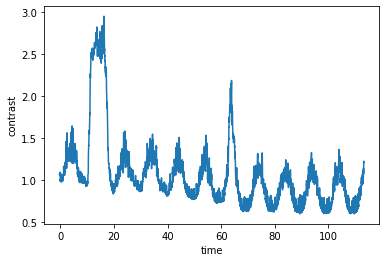

In [102]:
# normalize world movie and calculate contrast
img_norm = (world_vid-np.mean(world_vid,axis=0))/np.std(world_vid,axis=0)
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:6000],contrast[0:6000])
plt.xlabel('time')
plt.ylabel('contrast')

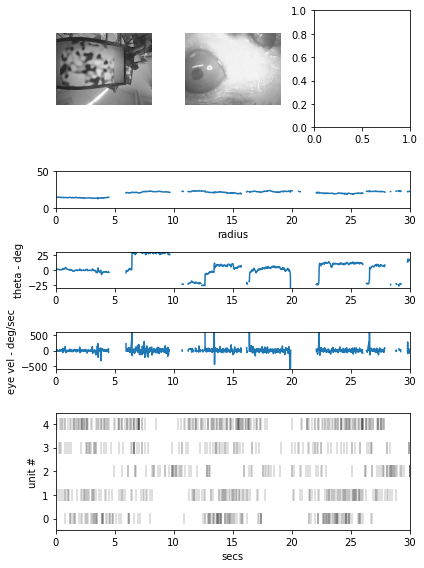

In [103]:
# plot another data figure (with contrast or speed)

fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(7,3)
axEye = fig.add_subplot(gs[0:2,1])
axWorld = fig.add_subplot(gs[0:2,0])
axTop = fig.add_subplot(gs[0:2,2])
axTheta = fig.add_subplot(gs[3,:])
axdTheta = fig.add_subplot(gs[4,:])
axVid = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[5:7,:])
#axRad = fig.add_subplot(gs[3,:])

tr = [0,30] # 340-385
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,0.5*eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# grab bag plot -speed / eye vel

#speed
#axdTheta.plot(topT[0:-1],sp); axdTheta.set_ylabel('speed cm/sec')
#axdTheta.set_ylim([0, 15])

#eve velocity
axdTheta.plot(eyeT[0:-1],dEye*60/2); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_ylim(-10*60,10*60); axdTheta.set_ylabel('eye vel - deg/sec')

axdTheta.set_xlim(tr[0],tr[1]); 

#plot contrast or radius
#axVid.plot(worldT,contrast/2.5)
#axVid.set_ylim([0, 1.1]); axVid.set_ylabel('contrast')

axVid.plot(eyeT,0.5*(eye_params.sel(ellipse_params = 'longaxis') +eye_params.sel(ellipse_params = 'shortaxis')) )
axVid.set_xlabel('radius'); axVid.set_ylim([0, 50])
axVid.set_xlim(tr[0],tr[1]);



# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.25)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
#axR.spines['right'].set_visible(False)
#axR.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('cams_eyes_R_move_spikes_101520_wn_0_30.pdf')

In [104]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

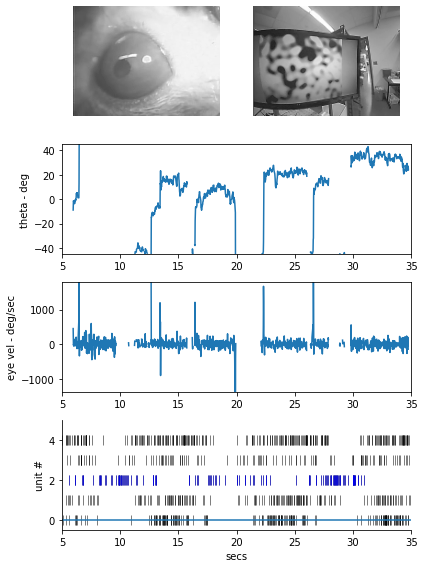

In [105]:
# make movie and sound

#unit to plot/record
this_unit = 2

#set up figure
fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(4,2)
axEye = fig.add_subplot(gs[0,0])
axWorld = fig.add_subplot(gs[0,1])
axTheta = fig.add_subplot(gs[1,:])
axdTheta = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[3,:])
#axRad = fig.add_subplot(gs[3,:])

#timerange and center frame (only)
tr = [5, 35]
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(0,160); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(np.flipud(world_vid[worldFr,:,:]),'gray',vmin=0,vmax=255,aspect = "equal")
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-45,45)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-23*60,30*60); axdTheta.set_ylabel('eye vel - deg/sec')

#plot radius?
#axRad.cla()
#axRad.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
#axRad.set_xlim(0,frameRange[-1]-frameRange[0]); 
#axRad.set_ylabel('radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
axR.vlines(goodcells.at[units[this_unit],'spikeT'],this_unit-0.25,this_unit+0.25,'b',linewidth=0.5)

axR.set_xlim(tr[0],tr[1]); axR.set_ylim(-0.5 , 5); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()

# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, "eye_world_spikes_092820_wn1_1.mp4", 100):
    for t in np.arange(tr[0],tr[1],1/30):
        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        axEye.set_xlim(0,160); axEye.set_ylim(0,120)
        
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(np.flipud(worldInterp(t)),'gray',vmin=0,vmax=255,aspect = "equal")
        
        #plot line for time, then remove
        ln = axR.vlines(t,-0.5,30,'b')
        writer.grab_frame()
        ln.remove()
        
###



# generate wave file
sp =np.array(ephys_data.at[units[this_unit],'spikeT'])-tr[0]
sp = sp[sp>0]
datarate = 30000
f = 440.0       # sound frequency (Hz)
# Compute waveform samples
tmax = tr[1]-tr[0]
t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in sp[sp<tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
wavio.write("wn_spike1.wav", x, datarate, sampwidth=1)

In [106]:
#https://cloudconvert.com/wav-to-mp3
# https://www.kapwing.com/tools/add-music-to-video

Text(0.5, 1.0, 'std dev of image')

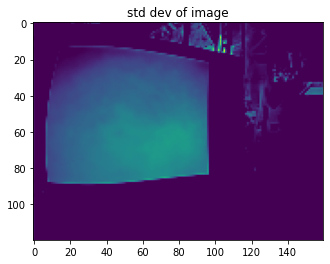

In [107]:
# normalize world video
std_im = np.std(world_vid,axis=0);
std_im[std_im<10] = 10;
img_norm = (world_vid-np.mean(world_vid,axis=0))/std_im
plt.imshow(std_im)
plt.title('std dev of image')

Text(0, 0.5, 'contrast')

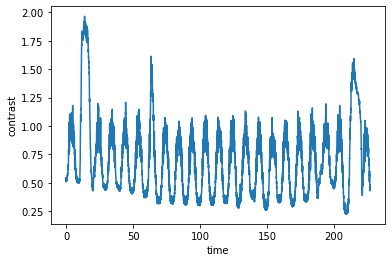

In [108]:
#calculate image contrast
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:12000],contrast[0:12000])
plt.xlabel('time')
plt.ylabel('contrast')


In [109]:
#set up timebase for subsequent analysis
dt = 0.025
t = np.arange(0, np.max(worldT),dt)

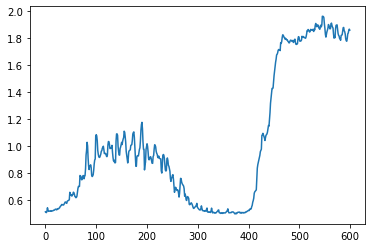

In [110]:
# interpolate and plot contrast
newc =interp1d(worldT,contrast)
contrast_interp = newc(t[0:-1])
contrast_interp.shape
plt.plot(contrast_interp[0:600])

In [111]:
# calculate firing rate at new timebase
ephys_data['rate'] = nan
ephys_data['rate'] = ephys_data['rate'].astype(object)
for i,ind in enumerate(ephys_data.index):
    ephys_data.at[ind,'rate'],bins = np.histogram(ephys_data.at[ind,'spikeT'],t)
ephys_data['rate']= ephys_data['rate']/dt
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells

,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,spikeT,waveform,t0,rate
6,764.6,2.5,good,30.485237,3,4,4.263284,good,2826,0,"[0.7644000000000001, 1.2200333333, 1.247066666...","[0.0100395055, 0.0036554276, 0.0046803541, 0.0...",38934.771289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32,536.6,2.9,good,30.527119,2,3,5.135250,good,3404,0,"[0.1678, 0.3977333333, 0.5629666667000001, 0.6...","[0.0247185733, 0.015519345200000001, 0.0148422...",38934.771289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0,..."
33,408.0,0.0,good,30.618151,3,4,1.875181,good,1243,0,"[4.9455333333, 5.6282333333, 6.1484, 6.1507666...","[0.008894111000000001, 0.0033597585, 0.0043601...",38934.771289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
35,761.0,0.0,good,30.321680,12,13,3.127313,good,2073,0,"[0.2978, 0.3816333333, 0.4817, 0.7696666667000...","[0.0154355047, 0.0070374236, 0.0077787391, 0.0...",38934.771289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
37,624.8,3.5,good,29.420898,3,4,6.616689,good,4386,0,"[0.146, 0.3689666667, 0.4158333333, 0.55176666...","[0.0163932666, 0.0052845916, 0.0064373915, 0.0...",38934.771289,"[0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0,..."


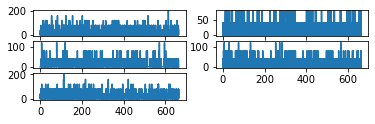

In [112]:
# plot firing rates
for i, ind in enumerate(goodcells.index):
    plt.subplot(7,2,i+1)
    plt.plot(t[0:-1],goodcells.at[ind,'rate'])

Text(0, 0.5, 'rate')

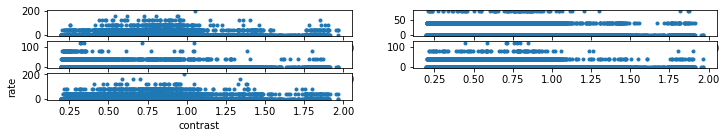

In [113]:
#scatter of contrast vs rate
plt.figure(figsize = (12,4))
for i, ind in enumerate(goodcells.index):
    plt.subplot(7,2,i+1)
    plt.plot(contrast_interp,goodcells.at[ind,'rate'],'.')
plt.xlabel('contrast')
plt.ylabel('rate')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'sp/sec')

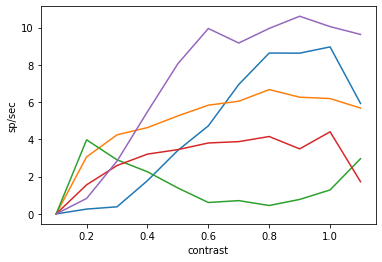

In [114]:
# calculate contrast - response functions
# mean firing rate in timebins correponding to contrast ranges
resp = np.empty((5,12))
crange = np.arange(0,1.2,0.1)
for i,ind in enumerate(goodcells.index):
    for c,cont in enumerate(crange):
        resp[i,c] = np.mean(goodcells.at[ind,'rate'][(contrast_interp>cont) & (contrast_interp<(cont+0.1))])
plt.plot(crange,np.transpose(resp))
#plt.ylim(0,10)
plt.xlabel('contrast')
plt.ylabel('sp/sec')
    

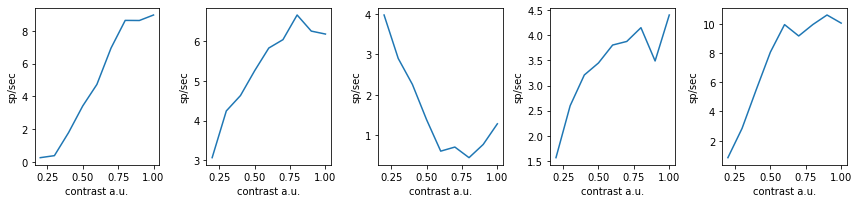

In [115]:
# plot individual contrast response functions in subplots
fig = plt.figure(figsize = (12,8))
for i, ind in enumerate(goodcells.index):
    plt.subplot(3,5,i+1)
    plt.plot(crange[2:-1],resp[i,2:-1])
   # plt.ylim([0 , max(resp[i,1:-3])*1.2])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig('contrast_resp_101520_fm1.pdf')

In [116]:
# create interpolator for movie data so we can evaluate at same timebins are firing rate
movInterp = interp1d(worldT,img_norm,axis=0)

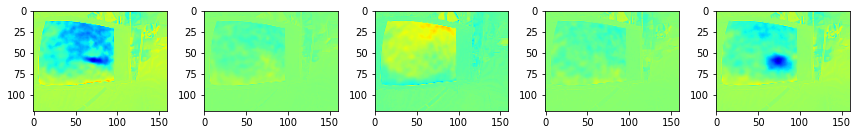

In [117]:
# calculate spike-triggered average
sta = 0
lag = 0.075
plt.figure(figsize = (12,8))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    for i in range(100,t.size-100):
        sta = sta+r[i]*(movInterp(t[i]-lag))
    plt.subplot(3,5,c+1)
    sta = sta/np.sum(r)
    #sta[abs(sta)<0.1]=0
    plt.imshow((sta-np.mean(sta) ),vmin=-0.6,vmax=0.6,cmap = 'jet')
plt.tight_layout()
plt.savefig('sta_101520_fm1_vm045.pdf')


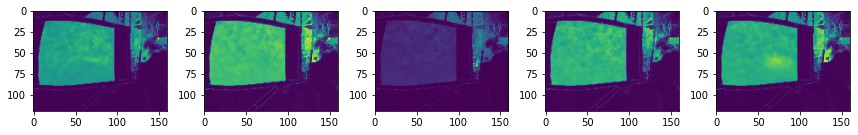

In [118]:
# calculate spike-triggered variance
sta = 0
lag = 0.1
plt.figure(figsize = (12,8))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    for i in range(5,t.size-10):
        sta = sta+r[i]*(movInterp(t[i]-lag))**2
    plt.subplot(3,5,c+1)
    sta = sta/np.sum(r)
    plt.imshow(sta)
plt.tight_layout()

(array([4.305e+03, 2.722e+03, 1.664e+03, 9.360e+02, 6.310e+02, 3.810e+02,
        2.310e+02, 1.450e+02, 8.800e+01, 6.700e+01, 4.700e+01, 2.300e+01,
        1.600e+01, 1.200e+01, 1.200e+01, 4.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5]),
 <a list of 29 Patch objects>)

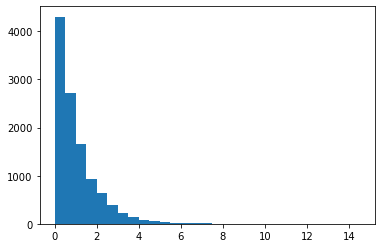

In [129]:
plt.hist(np.abs(dEye),np.arange(0,15,0.5))

<ipython-input-131-f90a87823dff>:5: RuntimeWarning: invalid value encountered in greater
  upsacc = eyeT[np.append(dEye,0)>sthresh]
<ipython-input-131-f90a87823dff>:7: RuntimeWarning: invalid value encountered in less
  downsacc= eyeT[np.append(dEye,0)<-sthresh]


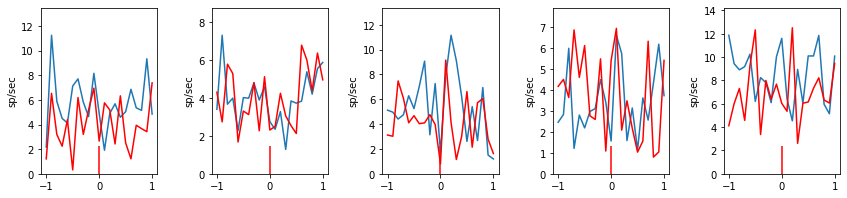

In [131]:
# calculate saccade-locked psth
fig = plt.figure(figsize = (12,8))
trange = np.arange(-1,1.1,0.1)
sthresh = 6;
upsacc = eyeT[np.append(dEye,0)>sthresh]
upsacc = upsacc[upsacc>2]
downsacc= eyeT[np.append(dEye,0)<-sthresh]
downsacc = downsacc[downsacc>2]
upsacc_avg = np.zeros((units.size,trange.size))
downsacc_avg = np.zeros((units.size,trange.size))
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    for s in upsacc:
        upsacc_avg[i,:] = upsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    for s in downsacc:
        downsacc_avg[i,:]= downsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/downsacc.size
    plt.subplot(3,5,i+1)
    plt.plot(trange,upsacc_avg[i,:])
    plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(upsacc_avg[i,:])*1.2])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig('saccade_092820_fm1.pdf')
        


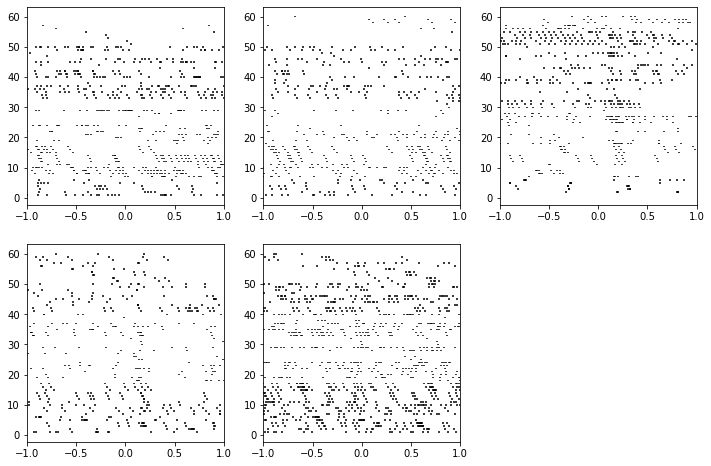

In [175]:
fig = plt.figure(figsize = (12,8))
for i, ind in enumerate(goodcells.index):
    sp = np.array(goodcells.at[units[i],'spikeT'])
    plt.subplot(2,3,i+1)
    n = 0
    for s in upsacc:
        n= n+1
        sd = np.abs(sp-np.array(s))<10
        sacc_sp = sp[sd]
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25)
    plt.xlim(-1,1)


In [172]:
upsacc

<xarray.DataArray 'timestamps' (frame: 60)>
array([  3.5666145,   5.9528095,   6.4418145,   6.4579235,   7.0408545,
         7.5043165,  12.6497885,  13.4159455,  13.4474205,  14.8803935,
        16.4184035,  22.2919645,  22.3080735,  22.3230175,  26.5651165,
        26.5953765,  26.6114855,  29.8355805,  35.4381665,  40.6767715,
        40.9804895,  46.3825885,  60.9997535, 105.8859615, 109.7018275,
       109.7618015, 119.0303075, 120.6322915, 123.4072415, 129.5281575,
       129.5436005, 129.6413535, 132.3128545, 132.3289635, 132.8161885,
       134.6171615, 165.2682655, 177.9978205, 209.0657125, 223.1801055,
       226.1640485, 226.1799395, 229.9732385, 236.9978335, 252.2151775,
       254.7850975, 288.6845155, 447.9439525, 453.3683805, 455.0405985,
       459.5059555, 459.5458525, 459.7452645, 459.7613735, 459.9613855,
       460.2733155, 511.0806055, 547.6362595, 547.6782305, 558.1981345])
Coordinates:
  * frame       (frame) int64 217 344 367 368 403 ... 27510 29465 29467 30042
    timestamps  (frame) float64 3.894e+04 3.894e+04 ... 3.948e+04 3.949e+04

In [151]:
sd.isempty

AttributeError: 'tuple' object has no attribute 'isempty'

In [145]:
sp

[4.9455333333,
 5.6282333333,
 6.1484,
 6.1507666667,
 6.7506666667,
 6.7615333333,
 6.7688,
 7.6684666667,
 8.1313666667,
 8.2393333333,
 8.3010333333,
 8.3723,
 8.6678333333,
 8.8099,
 9.2464666667,
 9.2977,
 9.6122,
 9.8396666667,
 9.8647666667,
 9.8875666667,
 9.9298,
 9.9622,
 10.0258,
 10.1032,
 10.1651666667,
 10.2181,
 10.2876,
 10.4371666667,
 10.5151666667,
 10.5917333333,
 10.6713333333,
 10.9500333333,
 11.3257333333,
 11.4636,
 11.9464333333,
 12.8131333333,
 12.8230333333,
 12.8514333333,
 12.9679333333,
 13.0339333333,
 13.0597,
 15.9234333333,
 15.9297,
 16.4088,
 16.5893333333,
 16.6645,
 17.5459,
 17.6063333333,
 17.7005666667,
 17.7996333333,
 17.9894666667,
 18.1134333333,
 18.2679,
 18.4695,
 18.9845,
 20.0347,
 20.0441333333,
 20.1821333333,
 20.6772666667,
 20.7583,
 21.1813,
 21.4279333333,
 21.5312666667,
 22.0999666667,
 22.2465,
 22.5035333333,
 22.5621,
 22.9038,
 25.1414666667,
 26.2216666667,
 26.2305333333,
 26.2637333333,
 26.7773,
 26.8279333333,
 27.27